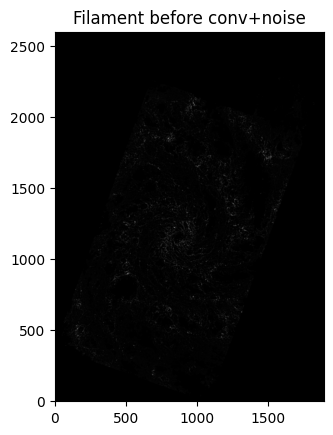

In [130]:
import photutils 

# set the FWHM of the filament
fwhmval=3 #16pc scale at 5.24 parcecs per pixel --> 3 pixels 

import numpy as np
import matplotlib.pyplot as plt
from photutils.datasets import make_noise_image
from photutils.psf import CircularGaussianPRF, make_psf_model_image
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.io import fits
from skimage.morphology import skeletonize
import cv2

#Composite skeleton from SOAX. Gives coordinates of sources in model
original_image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/Composites/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_Composites.fits"
with fits.open(original_image_path) as hdul:
    coords_data = hdul[0].data
    header_1 = hdul[0].header

#Original image path
# original_image_path =  "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits"
original_image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_drawinfill_16pc_sourceRemovalForSyntheticMaps.fits" #sources removed original image
with fits.open(original_image_path) as hdul:
    data = hdul[0].data
    header = hdul[0].header
    data = data[0]

#Dilate the composite map from soax and then skeletonize to get smooth, 1 pixel wide, filaments for the PSF model
data[np.isnan(data)] = 0
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.morphologyEx(coords_data, cv2.MORPH_CLOSE, kernel)
dilated_image = skeletonize(dilated_image)
coords_data= dilated_image.astype(np.uint8)
    
odata=data #original no noise

plt.imshow(data, origin='lower', cmap='gray')
plt.title('Filament before conv+noise')
plt.show()


In [131]:
#must define uncertainty in data and subtract background
import copy
from photutils.background import Background2D, MedianBackground
Scalepix = 5.24
noise_min = 10**-2

threshold = 10**-20 #pixels below this value will be seeds for mask

data_to_mask = data

mask_copy = copy.deepcopy(data_to_mask)

#Dilate White Pixels
mask_copy[mask_copy > threshold] = 255
mask_copy = mask_copy.astype(np.uint8)
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.dilate(mask_copy, kernel, iterations= 5) 

#threshold other way
copy_image = copy.deepcopy(data_to_mask).astype(np.float32)
copy_image[dilated_image < threshold] = np.nan
mask = np.isnan(copy_image)

#set up binary mask
binary_mask = np.zeros_like(copy_image, dtype=np.uint8)
binary_mask[mask] = 255
binary_mask[~mask] = 0

#dilate the mask
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

dilated_image = copy.deepcopy(data_to_mask).astype(np.float32)
dilated_image[dilated_mask==255] = np.nan

#make a mask based on dilated image, true value indicates pixel should be masked
mask = np.isnan(dilated_image)
assert(not np.isnan(mask).any())

                
#subtract bkg
bkg_estimator = MedianBackground()

#set box size
box_size = round(10.*Scalepix/2)*2+1

# if(box_size < .02* np.min((np.shape(data)[0], np.shape(data)[1]))):
#     print("Correcting box size")
#     box_size = int(.02*np.min((np.shape(data)[0], np.shape(data)[1]))) * 2 + 1 #Make box 2% of smaller image dimension...appears to work well

bkg = Background2D(data, box_size=box_size, coverage_mask = mask, exclude_percentile = 11, filter_size=(3,3), bkg_estimator=bkg_estimator) #Very different RMS with mask. Minimum noise is MUCH larger. 

data -= bkg.background #subtract bkg

data[data < 0] = 0 #Elimate neg values since this is over estimating the background. 

noise = bkg.background_rms 

noise[noise < noise_min] = noise_min #replace unphysical and absent noise with 10^-3 

assert(np.mean(noise !=0))

#data is background subtracted and noise array generated

In [132]:
from photutils.background import LocalBackground, MMMBackground
bkgstat = MMMBackground()
localbkg = LocalBackground(1, 6, bkgstat) #5 to 10 defines an annulus in pixels, 1 to 4 worked well

from photutils.psf import SourceGrouper
grouper = SourceGrouper(min_separation=1)

In [133]:
#set up for forced photometry, NOT allowing positions along filament to vary (only flux, which I also bound in the nearly-positive range)
#note I originally boosted the model FWHM to account for pixelization in pre-convolved filament, but this made fit scaled high w.r.t. image (leaving strong negative scar)

psf_model = CircularGaussianPRF(flux=1, fwhm=(fwhmval)) #No longer divide fwhmval/2.35
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
psf_model.flux.min = -1. * np.std(noise)
psf_model.fixed
psf_model.bounds

{'flux': (-0.06516728381288615, None), 'x_0': (None, None), 'y_0': (None, None), 'fwhm': (1.1754943508222875e-38, None)}

In [134]:
import numpy as np
from astropy.table import QTable
from photutils.psf import PSFPhotometry

# Find nonzero pixel coordinates based on output from SOAX that was skeletonized earlier
y_coords, x_coords = np.where(coords_data > 0)

# Create a new QTable with these coordinates
init_params = QTable()
init_params['x'] = x_coords
init_params['y'] = y_coords

# Define PSF fitting region
psf_shape = (2*int(np.ceil(fwhmval)) + 1, 2*int(np.ceil(fwhmval)) + 1)
fit_shape = psf_shape
print(f"PSF Shape: {psf_shape}")

psfphot = PSFPhotometry(psf_model, fit_shape, aperture_radius=5, localbkg_estimator=localbkg, grouper = grouper)
phot = psfphot(data, error=noise, init_params=init_params)


#Local bkg subtraction
# psfphot = PSFPhotometry(psf_model, fit_shape, aperture_radius=5,
#                         localbkg_estimator=localbkg_estimator, xy_bounds = 1) #local bkg subtraction and sources have a d.o.f
# phot = psfphot(data, error=noise, init_params=init_params)


PSF Shape: (7, 7)


KeyboardInterrupt: 

In [ ]:
print(phot['x_init','x_fit'])
# print(phot['y_init','y_fit'])
phot['local_bkg'].info.format = '.4f'  # optional format
print(np.median(np.array(phot['local_bkg'])))


x_init x_fit 
------ ------
   910  910.0
   910  910.0
   910  910.0
   910  910.0
   911  911.0
   911  911.0
   911  911.0
   912  912.0
   949  949.0
   913  913.0
   ...    ...
   742  742.0
   743  743.0
   744  744.0
   745  745.0
  1710 1710.0
  1710 1710.0
  1710 1710.0
  1710 1710.0
  1710 1710.0
  1711 1711.0
Length = 96629 rows
0.0522699921976906


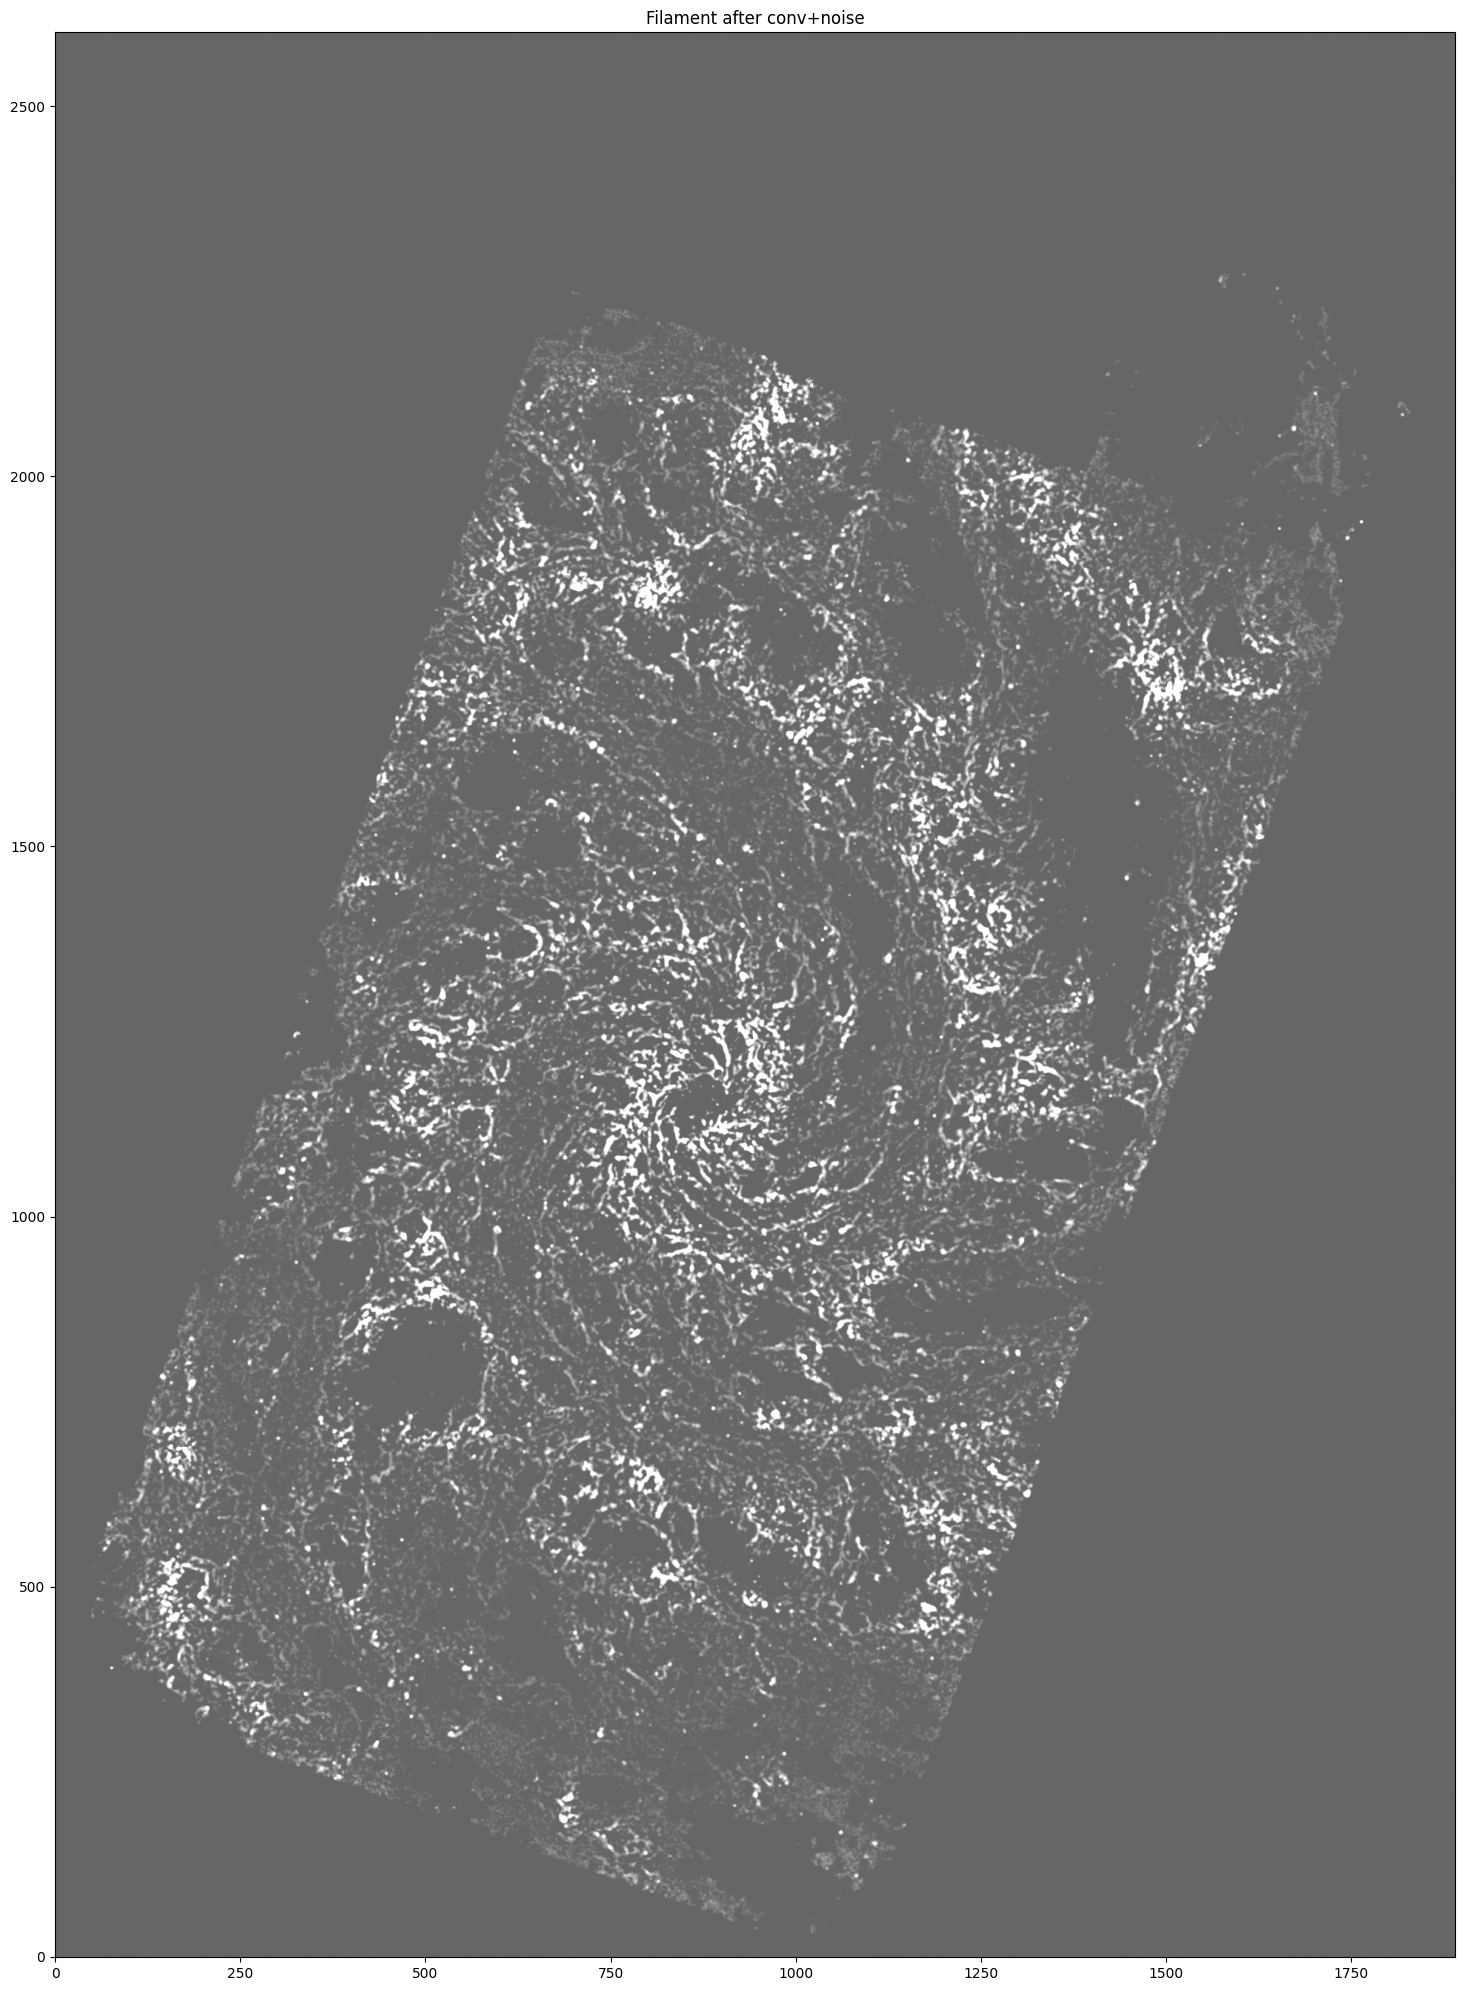

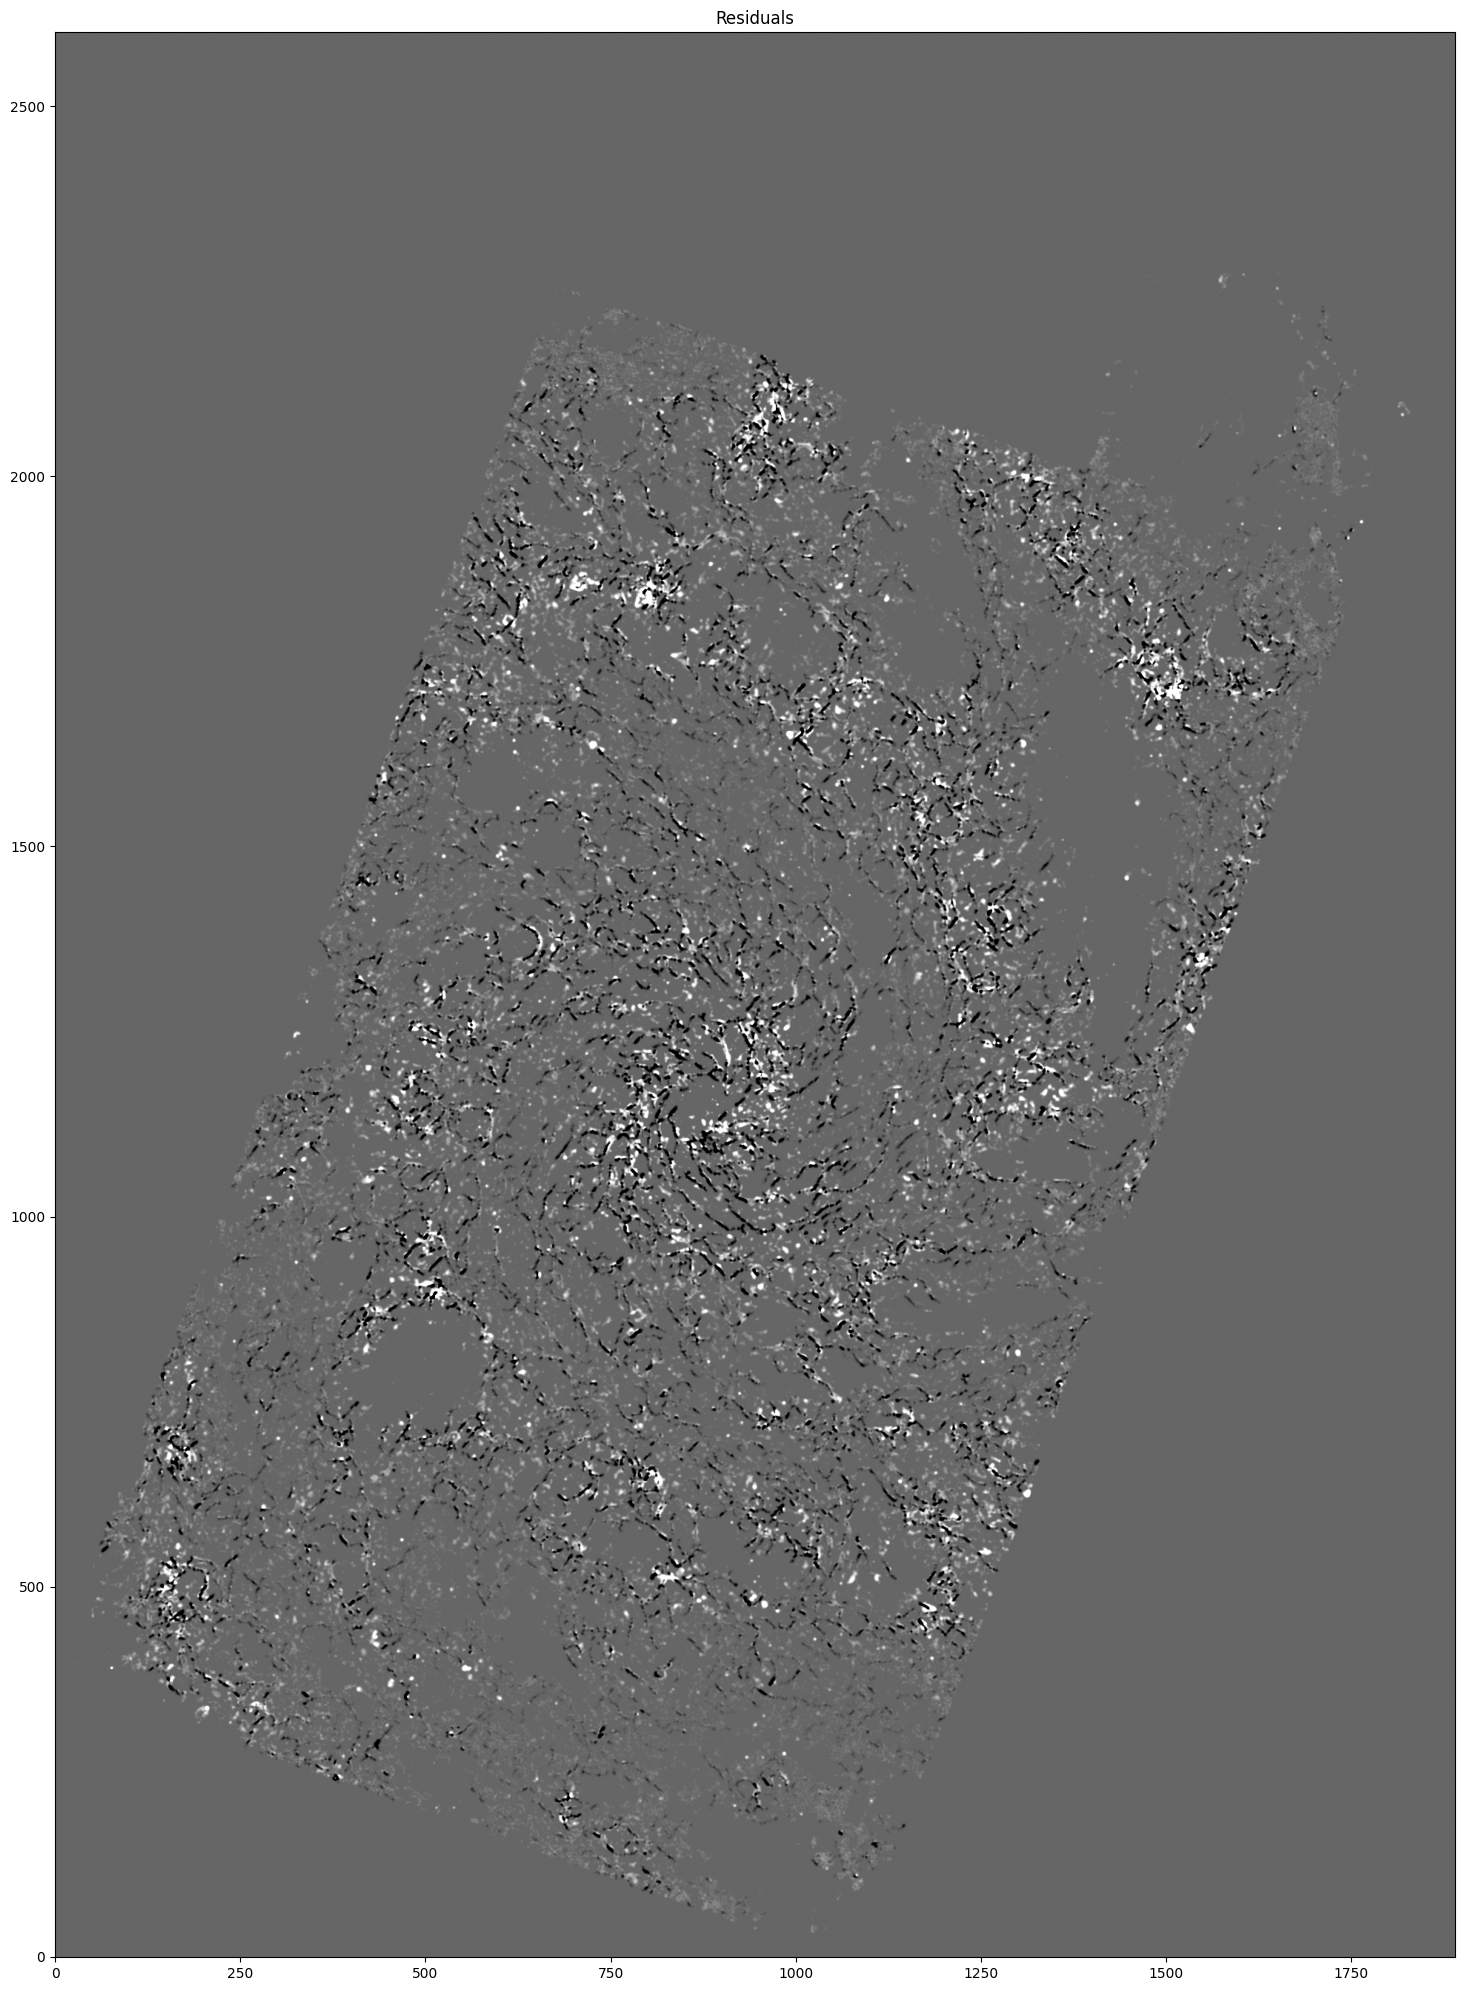

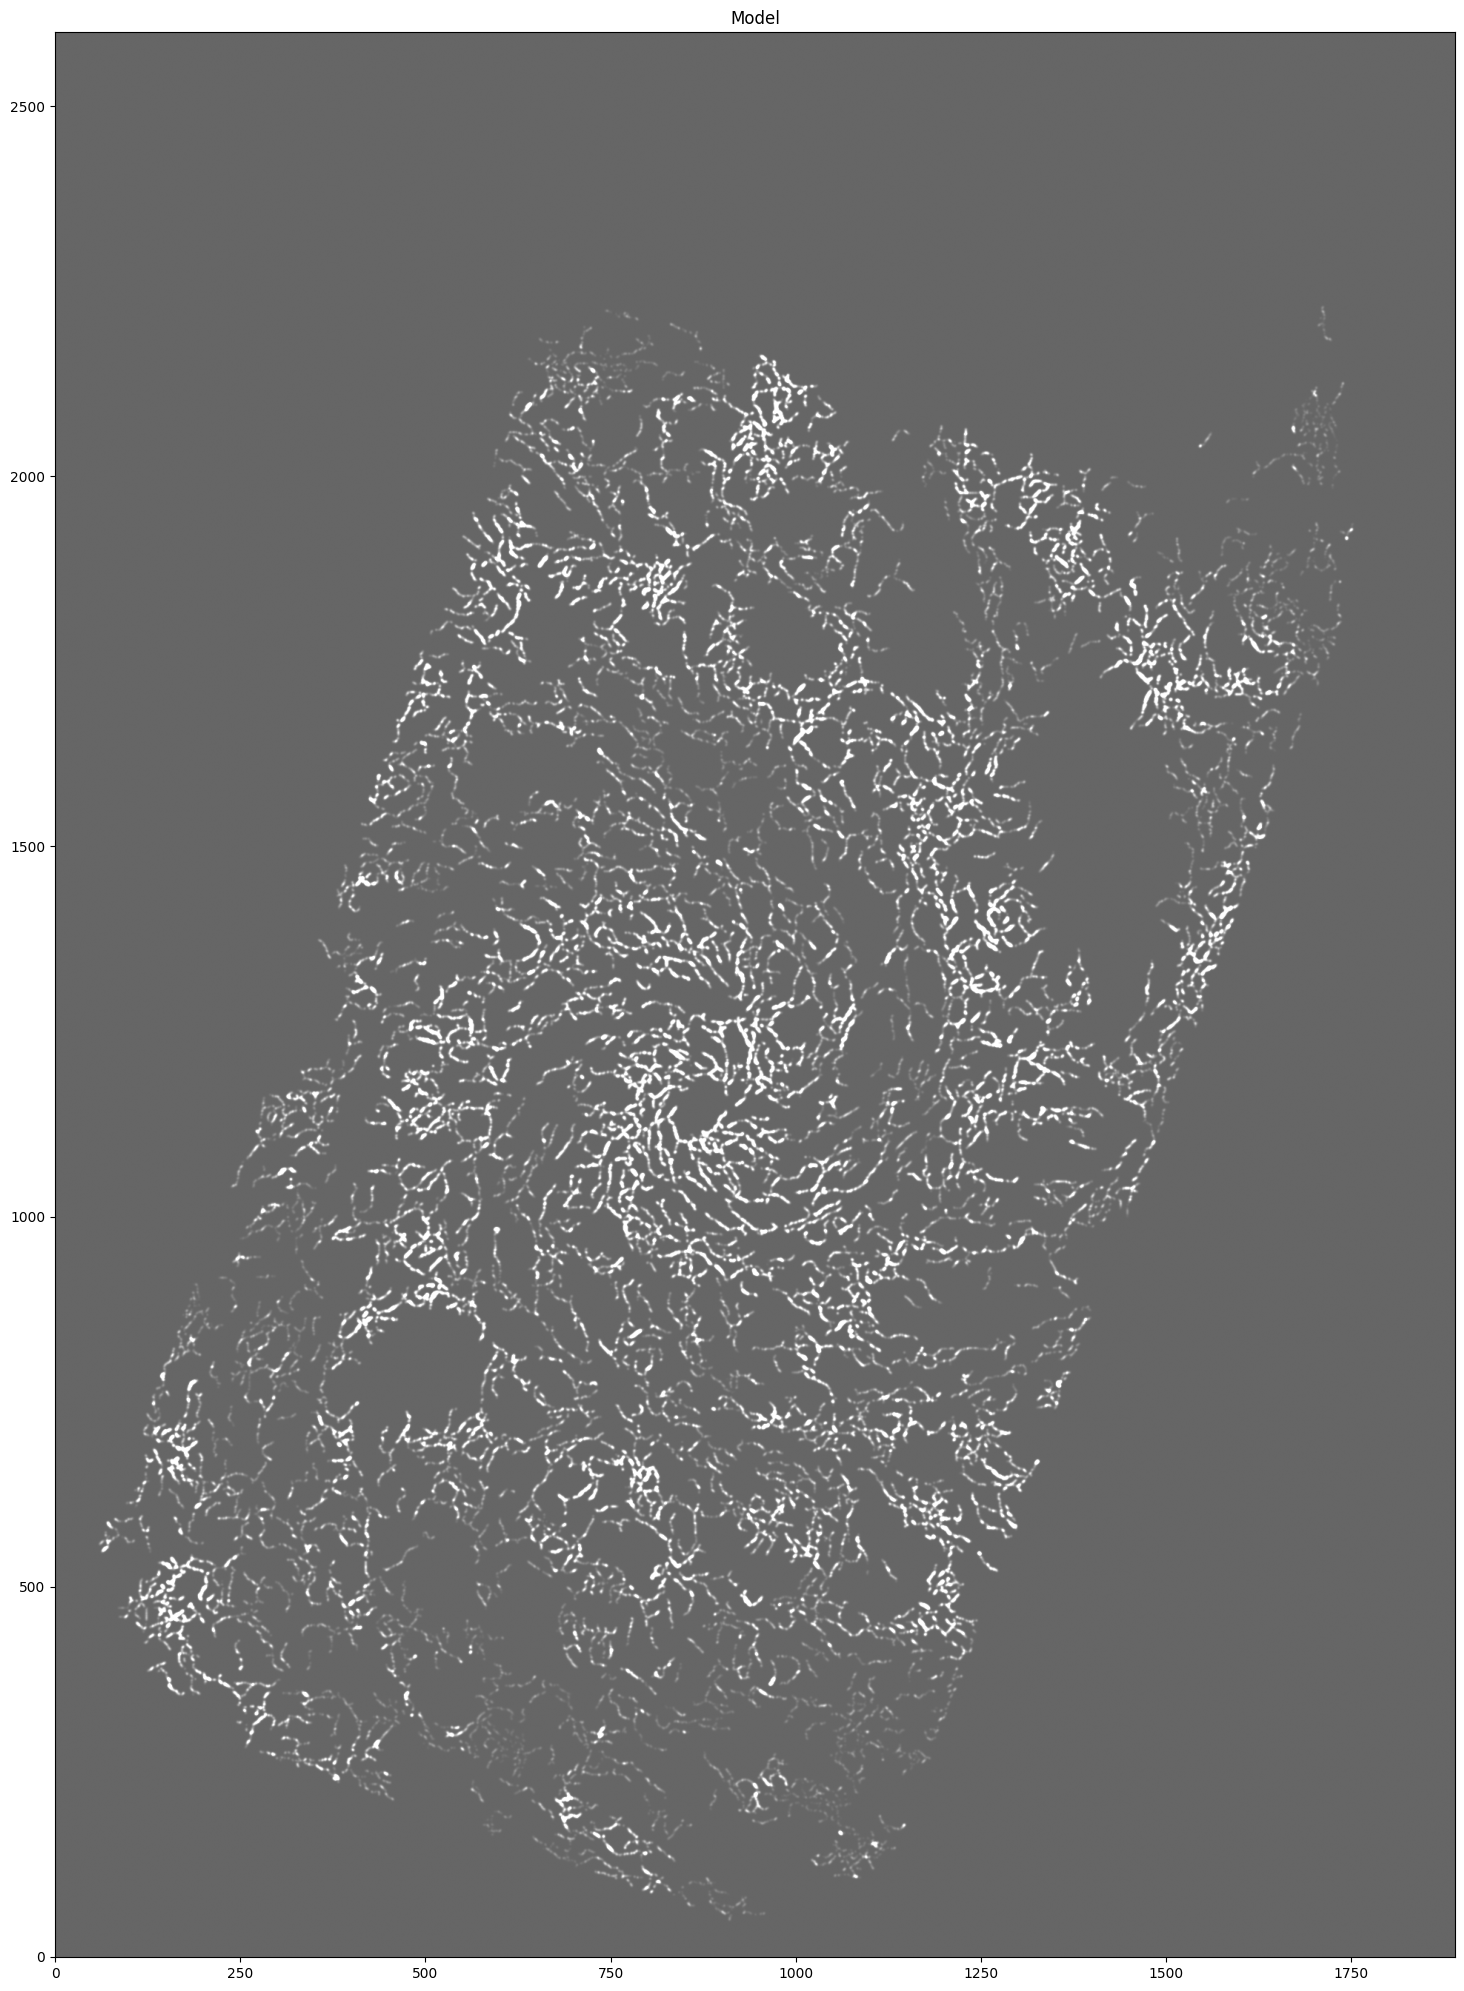

In [ ]:
# Compute residuals and model
resid = psfphot.make_residual_image(data)

model = (data - resid)  # Model is data minus residuals

flux_model = np.sum(model)
flux_original_over_filaments = np.sum(data[model != 0])
factor = flux_original_over_filaments/flux_model


# model = factor * model #Scale total flux to be equivalent along filaments

save_path =  "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W_CDDss0016pc_ModelMap_SorcesRemoved.fits"

# Save the model as a FITS file
hdu = fits.PrimaryHDU(model, header =header_1)
hdu.writeto(save_path, overwrite=True)

plt.figure(figsize = (25,25))
# Display images
plt.imshow(data, origin='lower', cmap='gray', vmin=-3.*np.std(data), vmax=np.percentile(data, 99))
plt.title('Filament after conv+noise')
plt.show()

plt.figure(figsize = (25,25))
plt.imshow(data-model, origin='lower', cmap='gray', vmin=-3.*np.std(data), vmax=np.percentile(data, 99))
plt.title('Residuals')
plt.show()

plt.figure(figsize = (25,25))
plt.imshow(model, origin='lower', cmap='gray', vmin=-3.*np.std(data), vmax=np.percentile(data, 99))
plt.title('Model')
plt.show()

In [ ]:
#Stats on model
cmodel = model.copy()
flux_model = np.sum(cmodel)
flux_original_over_filaments = np.sum(data[cmodel != 0])

print(f"flux of model: {np.sum(cmodel):.3e}")
print(f"total flux of original: {np.sum(data):.3e}")
print(f"flux of original over filaments in model: {np.sum(data[cmodel != 0]):.3e}")

flux_model = np.sum(cmodel)
flux_original_over_filaments = np.sum(data[cmodel != 0])
percent_difference = (flux_model - flux_original_over_filaments) / flux_original_over_filaments * 100
print(f"percent difference between flux of model and flux of original over filaments: {percent_difference:.2f}%")


flux of model: 2.985e+05
total flux of original: 3.219e+05
flux of original over filaments in model: 2.887e+05
percent difference between flux of model and flux of original over filaments: 3.39%


In [ ]:
#Test to see if the ratio between model and data is consistent
ratio = model/data
ratio[np.isnan(ratio)] = 0
ratio = np.divide(model, data, out=np.zeros_like(model), where=data!=0)
ratio = ratio[ratio != 0]
print(f'Mean and standard deviation of ratios, mean: {np.mean(ratio)}, and std: {np.std(ratio)}') #Huge standard deviation Unfortunately

Mean and standard deviation of ratios, mean: 2.510623361616398, and std: 136.9980505698385


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_81596/1698474912.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = model/data
/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_81596/1698474912.py:2: RuntimeWarning: invalid value encountered in divide
  ratio = model/data


**Loop to Test Parameters**

In [118]:
from itertools import product
from astropy.nddata import Cutout2D
from photutils.psf import PSFPhotometry
from photutils.background import LocalBackground, MMMBackground

# Step 1: Create central cutout (300x300)
cutout_size = (300, 300)
ny, nx = data.shape
position = (ny // 2, nx // 2)
cutout = Cutout2D(data, position, cutout_size)
cutout_noise = Cutout2D(noise, position, cutout_size).data
cutout_coords = Cutout2D(coords_data, position, cutout_size).data

# Get filament coordinates in cutout
y_coords, x_coords = np.where(cutout_coords > 0)
init_params = QTable()
init_params['x'] = x_coords
init_params['y'] = y_coords

# Step 2: Set up PSF
from photutils.psf import CircularGaussianPRF
psf_model = CircularGaussianPRF(flux=1, fwhm=(fwhmval))
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
psf_model.flux.min = -1. * np.std(noise)
# psf_model.flux.max = 2. * np.std(noise)

# Step 3: Optimization loop
best_diff = np.inf
best_params = None

aperture_radii = [4, 5, 6]
bkg_rings = [(1, 6), (3, 9), (2, 8)]

for radius, (r_in, r_out) in product(aperture_radii, bkg_rings):
    try:
        localbkg = LocalBackground(r_in, r_out, MMMBackground())
        psfphot = PSFPhotometry(psf_model, fit_shape=(7, 7),
                                aperture_radius=radius,
                                localbkg_estimator=localbkg, xy_bounds=1, grouper = grouper)

        phot = psfphot(cutout.data, error=cutout_noise, init_params=init_params)

        resid = psfphot.make_residual_image(cutout.data)
        model = (cutout.data - resid)

        flux_model = np.sum(model)
        flux_data = np.sum(cutout.data[model != 0])
        percent_diff = (flux_model - flux_data) / flux_data * 100

        print(f"Radius={radius}, annulus=({r_in},{r_out}): {percent_diff:.2f}%")

        if abs(percent_diff) < best_diff:
            best_diff = abs(percent_diff)
            best_params = (radius, r_in, r_out)

    except Exception as e:
        print(f"Skipped combo Radius={radius}, Annulus=({r_in},{r_out}) due to error: {e}")

print("\n✅ Best Parameter Set:")
print(f"Aperture Radius: {best_params[0]}, Annulus: ({best_params[1]}, {best_params[2]})")
print(f"→ Percent Difference: {best_diff:.2f}%")


KeyboardInterrupt: 